In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
df = pd.read_csv("../preprocessed_data/preprocessed_train.csv")

# PCA

In [3]:
def plot_variance_content(df):
    pca = PCA()
    pca.fit(df)
    variance_ratio = pca.explained_variance_ratio_
    x = np.arange(len(variance_ratio))

    plt.bar(x, variance_ratio)
    plt.xlabel('Kolumny')
    plt.ylabel('Zawarta wariancja')
    plt.xticks(x)
    plt.show()

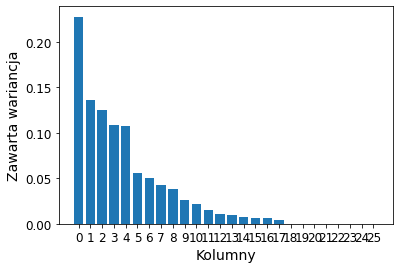

In [4]:
plot_variance_content(df)

In [5]:
def plot_explained_variance(data, variance_ratio_threshold=0.95, max_columns=15):

    pca = PCA()
    pca.fit(data)

    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)
    x = np.arange(1, len(variance_ratio) + 1)

    if max_columns:
        cumulative_variance = cumulative_variance[:max_columns]
        x = x[:max_columns]

    plt.plot(x, cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Liczba kolumn')
    plt.ylabel('Skumulowana wariancja wyjaśniona')
    plt.grid(True)

    if variance_ratio_threshold:
        plt.axhline(y=variance_ratio_threshold, color='r', linestyle='--')
        intersection_idx = np.argmax(cumulative_variance >= variance_ratio_threshold)
        plt.axvline(x=intersection_idx+1, color='black', linestyle='--')

    plt.show()


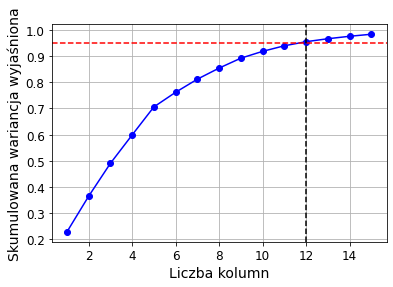

In [6]:
plot_explained_variance(df, 0.95)

In [7]:
df_pca_processed = pd.DataFrame(PCA(n_components = 12).fit_transform(df))

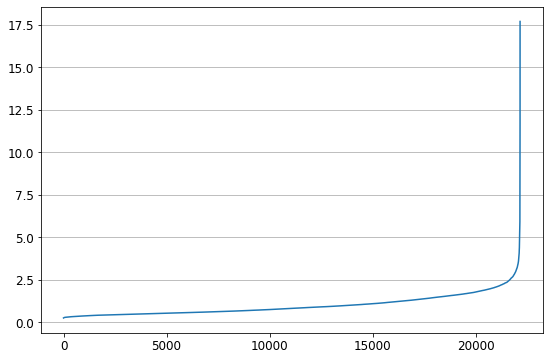

In [8]:
minPts = 24
nbrs = NearestNeighbors(n_neighbors=minPts).fit(df_pca_processed)
distances, indices = nbrs.kneighbors(df_pca_processed)
distanceDec = sorted(distances[:,minPts-1])

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(list(range(1,df_pca_processed.shape[0]+1)), distanceDec)
plt.grid(axis='y')
plt.show()

In [9]:
def plot_clusters(X, model):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

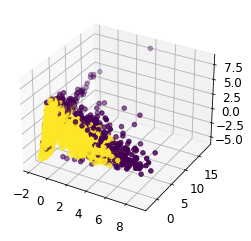

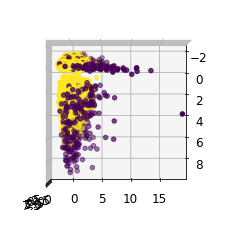

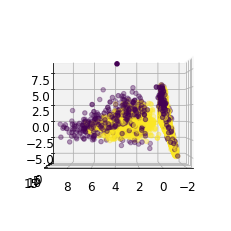

In [10]:
dbs = cluster.DBSCAN(eps=2., min_samples=24)
dbs.fit(df_pca_processed)

plot_clusters(df_pca_processed, dbs)

In [11]:
def count_clustering_scores(X, model, score_fun):

    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [12]:
from sklearn.metrics import silhouette_score
import pandas as pd

metrices = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

models = {
    # 'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
    # 'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
    # 'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
    # 'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
    'DBSCAN': dbs
}

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=df_pca_processed,model=models[model_key],
                                                                score_fun=metrices[metric_key])
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
DBSCAN,0.641751,5.944012,2.433605,4.212713,0.528094
